In [1]:
%load_ext autoreload
%autoreload 2


In [3]:

from data_config import Exp4NPN
from dataclasses import dataclass, field
from typing import List

from lib.mlm_singleton import init_singleton_scorer
mlm_scorer = init_singleton_scorer('roberta-large', output_attentions=True)



In [ ]:

from rozlib.libs.common.data.utils_jsonl import read_from_jsonl
from paper.exp4_npn.npn_utils import GPTOutput, HumanAnnotation
from paper.exp4_npn.npn_utils import filter_outputs

gpt_outputs: List[GPTOutput] = read_from_jsonl(Exp4NPN.npn_gpt_outputs, GPTOutput)
gpt_outputs_after = filter_outputs(gpt_outputs)
gpt_outputs_with_id = [(idx, go) for idx, go in enumerate(gpt_outputs_after)]



### read in judgements

In [24]:
from rozlib.libs.common.data.utils_dataclass import read_csv_to_dataclass

def read_judgements() -> List[HumanAnnotation]:
    all_judgements = read_csv_to_dataclass(HumanAnnotation, Exp4NPN.npn_acceptability_ratings_csv)
    for j in all_judgements:
        j.id = int(j.id)
        j.rating = int(j.rating)
    return all_judgements
all_judgements = read_judgements()

In [26]:
# check that everything lines up
for j in all_judgements:
    e = gpt_outputs_with_id[j.id]
    assert j.sentence == e[1].output

judgements_aligned = sorted(all_judgements, key=lambda x: x.id)

for j, e in zip(judgements_aligned, gpt_outputs_with_id):
    assert j.sentence == e[1].output

# all_judgements[0]

In [27]:
from collections import Counter


# note does not have bad words removed yet
def count_for_stats():
    c = Counter()
    for j, e in zip(judgements_aligned, gpt_outputs_with_id):
        if j.sentence.lower().find('jew') != -1 or j.sentence.lower().find('heterosexual') != -1:
            continue
        if j.rating < 4:
            continue
        c[e[1].prep] += 1
    print(c)
count_for_stats()


Counter({'upon': 64, 'after': 59, 'by': 32, 'to': 7})


In [28]:
from typing import Tuple


# below adapted from exp8_cogs (which was in turn prev adapted from sth else)
@dataclass
class GPTOut:
    id: int = field(init=False)
    sent: str = field(init=False)
    # indexes in the string
    # tgt_words: List[int] = field(init=False)
    tgt_word_offsets: List[Tuple[int, int]] = field(default_factory=list)
    words: List[str] = field(init=False)


def get_all_data_clean():
    ret_list: List[GPTOut] = []
    for idx, r in enumerate(gpt_outputs_after):
        dr = GPTOut()
        ret_list.append(dr)
        dr.id = idx
        dr.sent = r.output

        # get tgt words
        tgt_str = f"{r.noun.str_rep_no_space} {r.prep} {r.noun.str_rep_no_space}"
        phrase_idx_start = dr.sent.find(tgt_str)
        phrase_idx_end = phrase_idx_start + len(tgt_str)
        phrase_parts = r.output[phrase_idx_start: phrase_idx_end].split(" ")
        for pp, expected in zip(phrase_parts, [r.noun.str_rep_no_space, r.prep, r.noun.str_rep_no_space]):
            assert pp == expected, f"{pp} != {expected}"

        tgt_word_offsets = []
        start_idx = phrase_idx_start
        for w in phrase_parts:
            w_len = len(w)
            assert r.output[start_idx: start_idx + w_len] == w, f"{tgt_str[start_idx: start_idx + w_len]} != {w}"
            tgt_word_offsets.append((start_idx, start_idx + w_len))
            start_idx += w_len + 1  # add 1 for space
        dr.tgt_word_offsets = tgt_word_offsets
        dr.words = [r.output[x[0]: x[1]] for x in dr.tgt_word_offsets]
        for w, expected in zip(dr.words, [r.noun.str_rep_no_space, r.prep, r.noun.str_rep_no_space]):
            assert w == expected, f"{w} != {expected}"

    return ret_list

all_outs_clean = get_all_data_clean()


In [29]:
all_outs_clean[0]

GPTOut(id=0, sent='After a stressful week of work, she found herself in a cycle of binge after binge, unable to break free from the unhealthy pattern.', tgt_word_offsets=[(64, 69), (70, 75), (76, 81)], words=['binge', 'after', 'binge'])

In [30]:
from paper.exp3_magpie.corpus_magpie import WrappedIdiomWord
from transformers import BatchEncoding


# copied from exp8_cogs
class EntryWrapper:
    """ Adapted from MAGPIE_Wrapper"""
    def __init__(self, entry: GPTOut):
        """
        Steps:
        - get the total wordlist (contiguous non space strings)
        - get the alphabetic wordlist (candidates for masking)
        - get the list of idiom words (those with offsets)
            (checks that idiom words do not have spaces in them)

        """
        self.cog_entry = entry

        encoding = mlm_scorer.get_batch_encoding_for_sentence(entry.sent)

        # idiom token indices
        self.idiom_token_list: List[WrappedIdiomWord] = self.get_idiom_token_list(encoding)

        # later (other methods)
        # produce a list of possible tokens / words to mask from a sentence

    def get_idiom_token_list(self, encoding: BatchEncoding):
        offset_to_token_list_map: List[WrappedIdiomWord] = []
        for offset in self.cog_entry.tgt_word_offsets:
            wrapped_idiom = WrappedIdiomWord.wrap_idiom_using_encoding(self.cog_entry, offset, encoding)
            offset_to_token_list_map.append(wrapped_idiom)

        assert len(offset_to_token_list_map) == len(self.cog_entry.tgt_word_offsets)
        return offset_to_token_list_map


In [31]:
all_wrapped = []
for go in all_outs_clean:
    all_wrapped.append(EntryWrapper(go))

all_wrapped[0].idiom_token_list


[WrappedIdiomWord(offset=(64, 69), idiom_word_chars='binge', tokens=[15], token_words=['binge'], is_multiple_tokens=False, tokens_do_not_exact_match=False),
 WrappedIdiomWord(offset=(70, 75), idiom_word_chars='after', tokens=[16], token_words=['after'], is_multiple_tokens=False, tokens_do_not_exact_match=False),
 WrappedIdiomWord(offset=(76, 81), idiom_word_chars='binge', tokens=[17], token_words=['binge'], is_multiple_tokens=False, tokens_do_not_exact_match=False)]

In [32]:
from paper.exp3_magpie.corpus_magpie import EntryForProcessing
from tqdm import tqdm
from lib.scoring_fns import probability

"""
Accrue results by cx type and word (word or idx)
 - todo: check multitoken, eg
"""
# copied from exp8_cogs
def process_sent_exp8(
        entry_wrapped: EntryWrapper,
        print_preds = False
) -> List[float]:
    scores: List[float] = []
    entry = entry_wrapped.cog_entry
    entry_for_processing = EntryForProcessing(entry.id, entry.sent)
    tgt_words = [entry_wrapped.idiom_token_list[0], entry_wrapped.idiom_token_list[2]]  # skip the preposition
    for word_to_mask in tgt_words:
        assert word_to_mask.is_multiple_tokens is False and word_to_mask.tokens_do_not_exact_match is False
        t_idx = word_to_mask.tokens[0]
        inputs_ids = entry_for_processing.get_inputs_with_mask_for_token_at_idx(
            t_idx)
        # get likely fills
        outputs = mlm_scorer.get_model_outputs_for_input(inputs_ids)
        logits = outputs.logits

        # predictions is vocab_len [logit, logit, ... logit]
        token_logits = logits[0, t_idx]     # batch, idx, then vocab_len shape

        orig_token_id = entry_for_processing.input_ids[0, t_idx]

        # compute surprisal
        surprisal_score = probability(token_logits, orig_token_id)
        if print_preds:
            mlm_scorer._print_preds(token_logits)
        scores.append(surprisal_score.item())
    return scores

def get_all_scores():
    all_scores: List[List[float]] = []
    for cog_wrapped in tqdm(all_wrapped):
        scores = process_sent_exp8(cog_wrapped)
        all_scores.append(scores)
    return all_scores



In [33]:

# runs in 15 seconds on an m3 mac
all_scores = get_all_scores()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 301/301 [00:12<00:00, 23.31it/s]


In [39]:
print(all_scores[35])
ct = 0
for i, s_list in enumerate(all_scores):
    for s in s_list:
        if s < 0.5:
            print(s_list)
            print(all_wrapped[i].cog_entry.words[0])
            print(all_wrapped[i].cog_entry.sent)
            ct+=1
            break
print(ct)



[0.0007737943669781089, 2.1112222725605534e-07]
[0.2974763512611389, 0.9923263788223267]
guard
In the high-security prison, the inmates were watched guard by guard to ensure maximum vigilance.
[0.8869944214820862, 0.11219833791255951]
real
In this digital era, we must strive for authenticity, living real by real, not through the filtered lens of social media.
[0.26252731680870056, 0.5224451422691345]
real
In the art world, one can observe real upon real, as artists strive to capture the essence of reality in their work.
[0.18840014934539795, 0.0003085724310949445]
pen
The author, lost in his craft, scribbled away pen to pen, endlessly working on his novel.
[0.032162681221961975, 0.17842085659503937]
odds
The team had to fight odds by odds to finally win the championship.
[0.997226893901825, 8.551950304536149e-05]
legislation
The government continued to introduce legislation after legislation, striving to improve the country's economic situation.
[0.011708199046552181, 0.029575832188129

In [40]:
for oc, goa in zip(all_outs_clean, gpt_outputs_after):
    print(oc.sent, "\n", goa.output)

After a stressful week of work, she found herself in a cycle of binge after binge, unable to break free from the unhealthy pattern. 
 After a stressful week of work, she found herself in a cycle of binge after binge, unable to break free from the unhealthy pattern.
His unhealthy eating habits continued, binge by binge, leading to serious health problems. 
 His unhealthy eating habits continued, binge by binge, leading to serious health problems.
In his struggle with addiction, he found himself in a dangerous cycle of binge upon binge. 
 In his struggle with addiction, he found himself in a dangerous cycle of binge upon binge.
In the high-security prison, the inmates were watched guard by guard to ensure maximum vigilance. 
 In the high-security prison, the inmates were watched guard by guard to ensure maximum vigilance.
In the security company, they stacked guard upon guard, ensuring the safety of the high-profile client. 
 In the security company, they stacked guard upon guard, ensuri

In [41]:

tgt_ex = [(x, idx) for idx, x in enumerate(gpt_outputs_after) if x.noun.str_rep_no_space == "real"]
i = tgt_ex[0][1]
print(tgt_ex[0])
print(all_outs_clean[i])
all_scores[i]

(GPTOutput(noun=NounRep(id=588, token='Ġreal', str_rep=' real', str_rep_no_space='real'), prep='by', model='gpt-4-0613', output='In this digital era, we must strive for authenticity, living real by real, not through the filtered lens of social media.', finish_reason='stop'), 5)
GPTOut(id=5, sent='In this digital era, we must strive for authenticity, living real by real, not through the filtered lens of social media.', tgt_word_offsets=[(61, 65), (66, 68), (69, 73)], words=['real', 'by', 'real'])


[0.8869944214820862, 0.11219833791255951]

In [42]:
from pprint import pp
pp(gpt_outputs_after[96:])

[GPTOutput(noun=NounRep(id=14917,
                        token='Ġjew',
                        str_rep=' jew',
                        str_rep_no_space='jew'),
           prep='by',
           model='gpt-4-0613',
           output='In the heart of the city, they lived jew by jew, fostering '
                  'a close-knit community.',
           finish_reason='stop'),
 GPTOutput(noun=NounRep(id=14917,
                        token='Ġjew',
                        str_rep=' jew',
                        str_rep_no_space='jew'),
           prep='upon',
           model='gpt-4-0613',
           output='In the crowded synagogue, it was jew upon jew, all gathered '
                  'to celebrate the high holiday.',
           finish_reason='stop'),
 GPTOutput(noun=NounRep(id=21675,
                        token='Ġdisk',
                        str_rep=' disk',
                        str_rep_no_space='disk'),
           prep='after',
           model='gpt-4-0613',
           output='The c

In [43]:
from typing import Dict
from collections import defaultdict


# maps, e.g., "much less" => {0, 1} => List floats for the scores
# so aggreagator[much less][0] -> score list for much
def make_histograms():
    aggregator: Dict[str, List[float]] = defaultdict(list)
    for cog_entry, scores_set in zip(all_outs_clean, all_scores):
        for i, _ in enumerate(scores_set):
            key = f"{cog_entry.words[1]}"

            # for two cats only
            # key = f"{i}"
            aggregator[key].append(scores_set[i])
    return aggregator

all_aggregated = make_histograms()


In [44]:

import matplotlib.pyplot as plt
import seaborn as sns


198
['0', '1']


<Axes: title={'center': 'Distribution of contextual probabilities for indicated word'}, ylabel='Contextual Probability'>

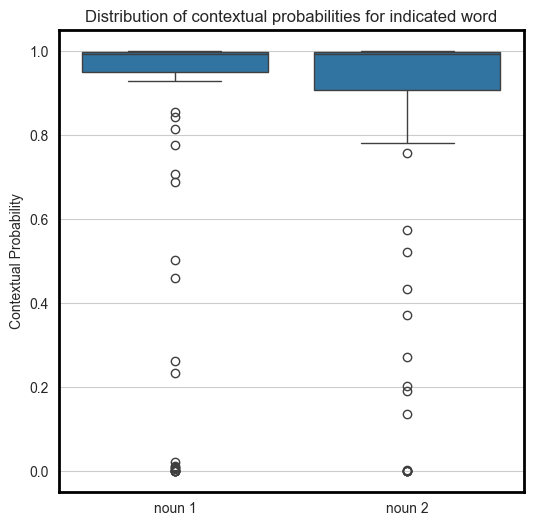

In [45]:
"""
Produces a boxplot for "upon" only
"""


def make_histograms():
    aggregator: Dict[str, List[float]] = defaultdict(list)
    for cog_entry, scores_set in zip(all_outs_clean, all_scores):
        if cog_entry.words[1] != "upon":
            continue
        for i, _ in enumerate(scores_set):
            key = f"{i}"
            aggregator[key].append(scores_set[i])
    return aggregator

all_aggregated = make_histograms()

fig, ax = plt.subplots(figsize=(6,6))
ax.set_ylim(-.05, 1.05)
ax.set_title("Distribution of contextual probabilities for indicated word")
ax.set_ylabel("Contextual Probability")
plt.rcParams.update({
    # 'text.usetex': True,
    'font.family': 'serif',  # Change to 'sans-serif', 'monospace', etc.
    'font.serif': ["cm"],
    'font.size': 10,         # Adjust font size
})
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set dark color (or 'white' for light mode)
    spine.set_linewidth(2)        # Adjust border thickness
# plt.xlabel("Construction & Word")
# categories, values = zip(*[(key, val) for key, vals in all_aggregated.items() for val in vals])

cat_val_tuples = [(key, val) for key, vals in all_aggregated.items() for val in vals]
cat_val_tuples_sorted = sorted(cat_val_tuples, key=lambda x: x[0])
categories, values = zip(*cat_val_tuples_sorted)
print(len(values))


# for two cats
cats_sorted = sorted(set(categories))
print(cats_sorted)
cat_names_nice = [
    f"noun 1",
    f"noun 2"
]
def cats_pretty():
    ret = []
    for c in categories:
        idx = cats_sorted.index(c)
        ret.append(cat_names_nice[idx])
    return ret
cats_prettied = cats_pretty()

sns.boxplot(x=cats_prettied, y=values)



In [46]:
# check alignment before filtering
for out, j in zip(all_outs_clean, judgements_aligned):
    assert out.sent == j.sentence

602


/Users/jsrozner/docs_local/_programming/research_constructions/constructions_repo/utils/utils_latex_matplot.py:63: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_77314/1479795298.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=cats_prettied, y=values, ax=ax,inner='quartile', cut=0, edgecolor="black",saturation=0.1, scale="width")
/Users/jsrozner/docs_local/_programming/research_constructions/constructions_repo/utils/utils_latex_matplot.py:63: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")


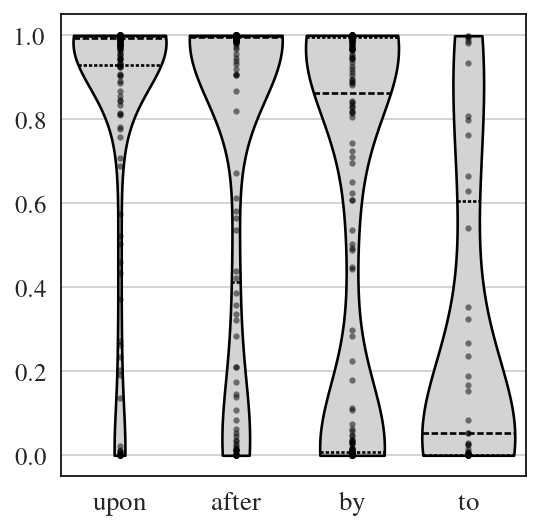

In [48]:

from rozlib.libs.plotting.utils_latex_matplot import config_matplot_for_latex, save_fig

"""
Produce boxplot for all
"""

# add or remove to produce the diff plots
judgement_filter = False

config_matplot_for_latex(13)
def make_histograms():
    aggregator: Dict[str, List[float]] = defaultdict(list)
    for out_clean, scores_set in zip(all_outs_clean, all_scores):
        j = judgements_aligned[out_clean.id]
        assert j.sentence == out_clean.sent
        # if j.rating > 2: continue
        if judgement_filter:
            if j.rating < 4: continue
        for i, _ in enumerate(scores_set):
            key = f"{out_clean.words[1]}"
            aggregator[key].append(scores_set[i])
    return aggregator

all_aggregated = make_histograms()

fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylim(-.05, 1.05)
# ax.set_title("Distribution of contextual probabilities for noun in NPN")
# ax.set_ylabel("Contextual Probability for Noun")
# ax.set_xlabel("Preposition in NPN")
# plt.rcParams.update({
#     # 'text.usetex': True,
#     'font.family': 'serif',  # Change to 'sans-serif', 'monospace', etc.
#     'font.serif': ["cm"],
#     'font.size': 10,         # Adjust font size
# })
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set dark color (or 'white' for light mode)
    # spine.set_linewidth(2)        # Adjust border thickness
# plt.xlabel("Construction & Word")
# categories, values = zip(*[(key, val) for key, vals in all_aggregated.items() for val in vals])

cat_val_tuples = [(key, val) for key, vals in all_aggregated.items() for val in vals]
order = ['upon', 'after','by', 'to']
cat_val_tuples_sorted = sorted(cat_val_tuples, key=lambda x: order.index(x[0]))
categories, values = zip(*cat_val_tuples_sorted)
print(len(values))


# for two cats
cats_prettied = categories

# sns.boxplot(x=cats_prettied, y=values)
sns.violinplot(x=cats_prettied, y=values, ax=ax,inner='quartile', cut=0, edgecolor="black",saturation=0.1, scale="width")
# Overlay Data Points (Jittered for Visibility)
for violin in ax.collections:
    violin.set_facecolor("lightgray")
sns.stripplot(x=cats_prettied, y=values, ax=ax,
              color="black", alpha=0.5, size=3, jitter=False)  # Adjust size & alpha

# config_matplot_for_latex(14)
# save_fig(fig, "npn_acceptable.pdf")

if judgement_filter:
    output_name = "npn_acceptable.pdf"
else:
    output_name = "npn_all.pdf"

config_matplot_for_latex(12)
save_fig(fig, output_name)




In [121]:
# investigate outliers:
i = -1
for out_clean, scores_set in zip(all_outs_clean, all_scores):
    i += 1
    if out_clean.words[1] != 'to': continue
    j = judgements_aligned[out_clean.id]
    # if j.rating < 4: continue
    if j.rating > 2: continue
    if scores_set[0] < 0.1 or scores_set[1] < 0.1:
        print(i)
        print("***")
        print(out_clean.sent)
        print(scores_set)
        print(j.rating)
        entrywrapped = EntryWrapper(out_clean)
        process_sent_exp8(entrywrapped, print_preds=True)


9
***
The author, lost in his craft, scribbled away pen to pen, endlessly working on his novel.
[0.18840014934539795, 0.0003085724310949445]
1
torch.Size([1, 23, 50265])
Entropy: 2.19; HHI: 0.247; step_score: 3.1968650817871094 
 pencil - 56.52 - 1.0
 pen - 55.68 - 0.433
 hand - 55.25 - 0.281
 paper - 54.52 - 0.136
 finger - 54.19 - 0.098
torch.Size([1, 23, 50265])
Entropy: 0.31; HHI: 0.91; step_score: 0.08489403873682022 
 paper - 63.87 - 1.0
 keyboard - 59.64 - 0.015
 page - 59.4 - 0.011
 hand - 58.27 - 0.004
 pad - 58.21 - 0.003
101
***
She was working on her programming project, writing comp to comp, until she finally found the solution.
[2.7656948077492416e-05, 0.007340485230088234]
1
torch.Size([1, 22, 50265])
Entropy: 3.93; HHI: 0.135; step_score: 3.833080530166626 
 code - 58.46 - 1.0
 programs - 56.86 - 0.203
 things - 56.32 - 0.118
 tests - 55.99 - 0.085
 something - 55.97 - 0.083
torch.Size([1, 22, 50265])
Entropy: 6.56; HHI: 0.007; step_score: 6.573331356048584 
 it - 52.85